In [1]:
!pip install shap

In [236]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import shap

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
%matplotlib notebook

In [3]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'Muon_Angle_m21'

args = {'N_edge_feats': 6,
        'N_dom_feats': 10,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 1,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '222t',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'rasmus_classification_muon_1500k.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'pulse_width, lc, SRTInIcePulses, string, dom, charge_log10, time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith, energy_log10',
        'TrTV': (0,1,1)
       }

In [4]:
# with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\Nu_lvl7_1Mio_unscaled_SRT.db") as con:
#     query = "SELECT event_no FROM truth"
#     old_event_nos = pd.read_sql(query,con)

# with sqlite3.connect(r"C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\raw_data\dev_level7_mu_e_tau_oscweight_newfeats_unscaled.db") as con:
#     query = "SELECT event_no FROM truth"
#     event_nos = pd.read_sql(query,con)

# ind = event_nos.isin(old_event_nos.values)
# event_nos = event_nos[(~ind).values].sample(1000000).values.reshape(-1)

In [5]:
filepath = os.path.join(path,'raw_data')

# centers = pd.DataFrame({'charge_log10': [-0.033858],
#                         'dom_time': [10700.0],
#                         'dom_x': [0],
#                         'dom_y': [0],
#                         'dom_z': [0],
#                         'width': [4.5],
#                         'rqe': [1.175]})
# scalers = pd.DataFrame({'charge_log10': [0.274158],
#                         'dom_time': [2699.0],
#                         'dom_x': [300],
#                         'dom_y': [300],
#                         'dom_z': [300],
#                         'width': [3.5],
#                         'rqe': [0.175]})
centers = pd.DataFrame({'charge_log10': [0],
                        'time': [0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [40],
                        'dom': [30],
                        'pulse_width': [4.5]})
scalers = pd.DataFrame({'charge_log10': [1],
                        'time': [1],
                        'dom_x': [1],
                        'dom_y': [1],
                        'dom_z': [1],
                        'lc': [0.5],
                        'SRTInIcePulses': [0.5],
                        'string': [20],
                        'dom': [15],
                        'pulse_width': [3.5]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

y_centers = pd.DataFrame({'energy_log10': [2.28962877],
                          'azimuth': [3.17179598],
                          'zenith': [0.99478726]})
y_scalers = pd.DataFrame({'energy_log10': [1.03477065],
                          'azimuth': [3.18754927],
                          'zenith': [1.11991644]})

y_centers = y_centers[args['targets'].split(', ')].values
y_scalers = y_scalers[args['targets'].split(', ')].values

def y_transform(df):
    df = df*y_scalers + y_centers
    return torch.tensor(df.values)

# def y_transform(df):
#     return torch.tensor(df.values)

# from typing import List
# @torch.jit.script
# def batch_transform(x,events: List[int]):
#     tmp_x = x.unsqueeze(1) - x
#     cart = tmp_x[:,:,-3:]
    
#     rho = torch.norm(cart, p=2, dim=-1).unsqueeze(2)
#     rho_mask = rho.squeeze() != 0
#     if rho_mask.sum() != 0:
#         cart[rho_mask] = cart[rho_mask] / rho[rho_mask]
#     tmp_x = torch.cat([cart,rho,tmp_x[:,:,:-3]],dim=2)
#     return torch.cat([tmp_x.mean(1),tmp_x.std(1),tmp_x.min(1)[0],tmp_x.max(1)[0],x],dim=1)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
#                                event_nos = event_nos,
                               x_transform = x_transform,
                               y_transform = y_transform,
#                                batch_transform = batch_transform,
                               shuffle = False)

In [6]:
device = torch.device('cuda')

import Model_Loaders.Model_21 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.eval();
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [7]:
N_background = 10
background = dataset.collate(dataset[np.random.choice(dataset.__len__(),N_background).tolist()]).to(device)
background

Batch(batch=[595], x=[595, 10], y=[30])

In [34]:
e = shap.DeepExplainer(model, [background.x[background.batch == i] for i in background.batch.unique()])

In [152]:
test = dataset[5192] #5192
shap_values = e.shap_values([test.x]);

In [153]:
np.asarray(shap_values).shape

(3, 1, 216, 10)

<IPython.core.display.Javascript object>


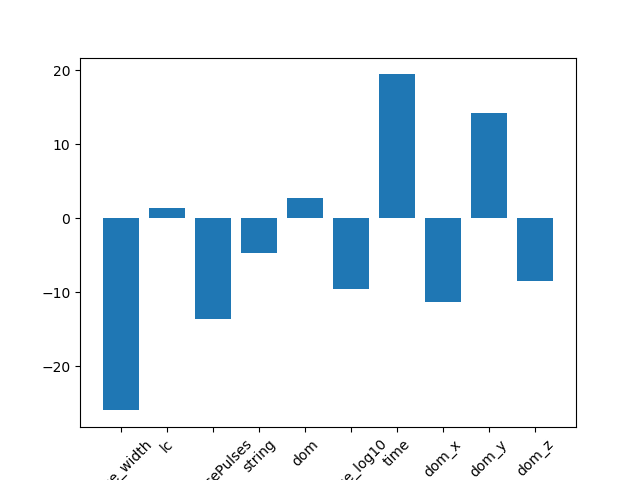

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

In [154]:
fig, ax = plt.subplots()
features = args['features'].split(', ')
ax.bar(features, shap_values[0][0].sum(0))
plt.xticks(rotation=45)

In [80]:
shap.initjs()

In [158]:
shap.force_plot(e.expected_value[1],shap_values[1][0],test.x.numpy(),features)

In [156]:
azt = test.y[:,0]
az_ze_p = model(test.x.to(device))[:,:2].cpu() + torch.tensor(args['output_offset'])
azp = az_ze_p[:,0]

<IPython.core.display.Javascript object>


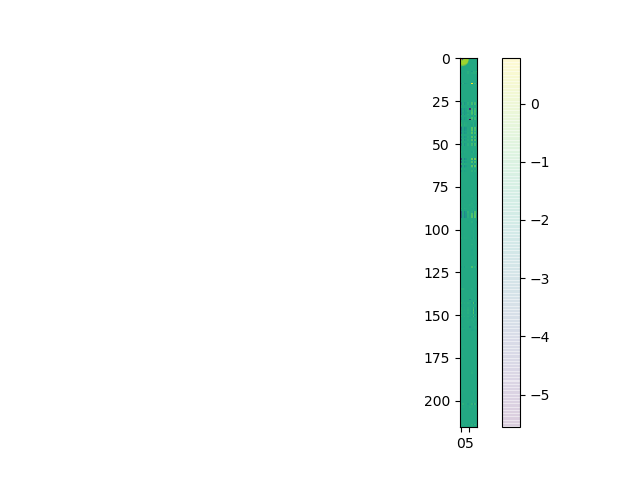

In [157]:
fig, ax = plt.subplots()
im = ax.scatter(test.x[:,-3],test.x[:,-2],c=shap_values[0][0].sum(1),alpha=0.1)

ax.plot([0,torch.cos(azp)],[0,torch.sin(azp)])
ax.plot([0,torch.cos(azt)],[0,torch.sin(azt)],ls='--')

plt.colorbar(im)

# fig, ax = plt.subplots()
# ax.scatter(test.x[:,-3].cpu(),test.x[:,-1].cpu(),c=shap_values[0][0].sum(1))

# fig, ax = plt.subplots()
# ax.scatter(test.x[:,-2].cpu(),test.x[:,-1].cpu(),c=shap_values[0][0].sum(1))

In [160]:
shap.force_plot(e.expected_value[1],shap_values[1][0],test.x.numpy(),features,matplotlib=True)

Exception: matplotlib = True is not yet supported for force plots with multiple samples!

In [167]:
shap.force_plot(e.expected_value[1],shap_values[1][0],test.x.numpy(),features)

In [180]:
X, Y = np.meshgrid(np.arange(0,11),np.arange(0,shap_values[0][0].shape[0]+1))

In [291]:
import time
global_row = None
curr_time = time.time()
def onclick(event):
    global curr_time
    global global_row
    row = int(event.xdata + 0.5)

    global_row = row
#     ax.set_title(row)
    if time.time() - curr_time > 0.1:
        curr_time = time.time()
        ax.set_title(time.time())
        index_line.set_xdata([row,row])
        fig.canvas.draw()

<IPython.core.display.Javascript object>


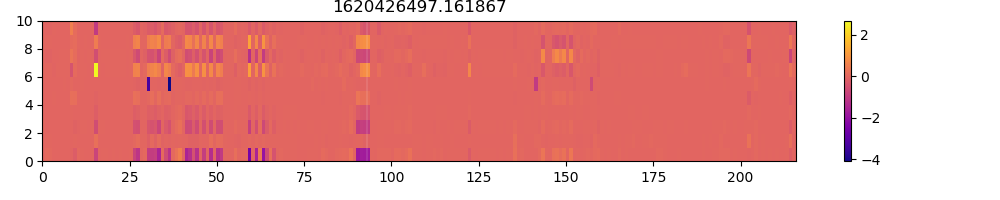

7

In [292]:
fig, ax = plt.subplots(figsize=(10,2))
# ax.imshow(shap_values[0][0].T)
im = ax.pcolor(shap_values[0][0].T,cmap='plasma')
index_line, = ax.plot([5,5],[0,10],'w',alpha=0.1)
fig.colorbar(im)
fig.tight_layout()
fig.canvas.mpl_connect('motion_notify_event',onclick)
# fig.canvas.mpl_connect('button_press_event',onclick)

In [274]:
# help(index_line)
index_line.set_xdata((100,100))

In [175]:
N_background = 100
N_test = 2

device = torch.device('cuda')

In [176]:
background = dataset.collate(dataset[[_ for _ in range(N_background)]]).to(device)
# test = dataset.collate(dataset[[_ for _ in range(N_background, N_background + N_test)]]).to(device)
# test.x.requires_grad_();
# test.x.requires_grad_()
# background.shape = background.x.shape
# test.shape = test.x.shape

In [370]:
test = dataset.collate([dataset[151]]).to(device)

In [382]:
Batch(test)

Batch(batch=Batch(batch=[72], x=[72, 10], y=[1, 3]))

In [379]:
# def f(x):

from torch_geometric.data import Data, Batch
class f:
#     def __init__(self):
#         self = model
    def eval(self):
        model.eval()
        return self
    def zero_grad(self):
        model.zero_grad()
    def children(self):
        return model.children()
    def __call__(self,*x):
#         batch = torch.zeros(x.shape[0],device=model.device,dtype=torch.int64)
        data_list = []
        for tmp_x in x:
            data_list.append(Data(x=tmp_x))
        data = dataset.collate(data_list)
        return model(data)

obj = f()

In [180]:
tmp = [background.x[background.batch == i] for i in background.batch.unique()]

In [378]:
help(shap.explainers)

Help on package shap.explainers in shap:

NAME
    shap.explainers

PACKAGE CONTENTS
    _additive
    _deep (package)
    _exact
    _explainer
    _gpu_tree
    _gradient
    _kernel
    _linear
    _partition
    _permutation
    _sampling
    _tree
    mimic
    other (package)
    pytree
    tf_utils

FILE
    c:\users\jv97\anaconda3\lib\site-packages\shap\explainers\__init__.py




In [25]:
explainer = shap.explainers._deep.deep_pytorch.PyTorchDeep(obj,tmp)

NameError: name 'obj' is not defined

In [371]:
shap_values = explainer.shap_values([test.x])

In [329]:
# shap_values[0][0].sum(0)

array([-0.70616354,  0.19951796,  1.58917121,  0.39522997,  0.09724784,
        0.21033649, -1.56469974, -0.62259722,  1.63036455,  0.49350378])

In [341]:
shap_values[0][0][test.x[:,2].cpu() == 1].mean(), shap_values[0][0][test.x[:,2].cpu() == -1].mean()

(0.0014621037176236402, 0.0017748311734353953)

In [372]:
azt = test.y[:,0]
azp = obj(test.x)[:,0] + 3.14

In [373]:
shap_values[0][0].sum(1)[torch.sin(azp).abs().cpu()*test.x[:,-3].cpu() < test.x[:,-2].cpu()].sum()


-0.9598477511694695

In [374]:
shap_values[0][0].sum(1)[torch.sin(azp).abs().cpu()*test.x[:,-3].cpu() > test.x[:,-2].cpu()].sum()

2.761222286759298

In [384]:
import shap
e = shap.DeepExplainer(model, tmp)

TypeError: forward() takes 2 positional arguments but 101 were given

In [196]:
help(shap.explainers._deep.deep_pytorch)

Help on module shap.explainers._deep.deep_pytorch in shap.explainers._deep:

NAME
    shap.explainers._deep.deep_pytorch

CLASSES
    shap.explainers._explainer.Explainer(shap._serializable.Serializable)
        PyTorchDeep
    
    class PyTorchDeep(shap.explainers._explainer.Explainer)
     |  PyTorchDeep(model, data)
     |  
     |  Uses Shapley values to explain any machine learning model or python function.
     |  
     |  This is the primary explainer interface for the SHAP library. It takes any combination
     |  of a model and masker and returns a callable subclass object that implements
     |  the particular estimation algorithm that was chosen.
     |  
     |  Method resolution order:
     |      PyTorchDeep
     |      shap.explainers._explainer.Explainer
     |      shap._serializable.Serializable
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, model, data)
     |      Build a new explainer for the passed model.
     |

In [245]:
e.shap_values(test.x)

TypeError: 'list' object is not callable

In [154]:
help(shap.DeepExplainer)

Help on class Deep in module shap.explainers._deep:

class Deep(shap.explainers._explainer.Explainer)
 |  Deep(model, data, session=None, learning_phase_flags=None)
 |  
 |  Meant to approximate SHAP values for deep learning models.
 |  
 |  This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we
 |  approximate the conditional expectations of SHAP values using a selection of background samples.
 |  Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar,
 |  Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating
 |  over many backgound samples Deep estimates approximate SHAP values such that they sum
 |  up to the difference between the expected model output on the passed background samples and the
 |  current model output (f(x) - E[f(x)]).
 |  
 |  Examples
 |  --------
 |  See :ref:`Deep Explainer Examples <deep_explainer_examples>`
 |  
 |  Method resolution or

In [69]:
from torch_scatter import scatter_sum, scatter_mean

def num_deriv(model, data, col, eps = 0.001):
    h = torch.zeros_like(data.x)
    h[:,col] += eps
    
    xph = data.clone()
    xph.x += h
    
    xmh = data.clone()
    xmh.x -= h
    
    f_xph = model(xph)
    f_xmh = model(xmh)
    return ((f_xph - f_xmh)/(2*eps)).cpu().detach()

a = num_deriv(model, test, 3, eps = 0.001)

In [70]:
def influence(model, data, col, eps = 0.001):
    derivs = num_deriv(model, data, col, eps)
    derivs = derivs.abs().mean(0)
    fig, ax = plt.subplots()
    ax.plot(derivs.numpy(),'xk')

N = 1024

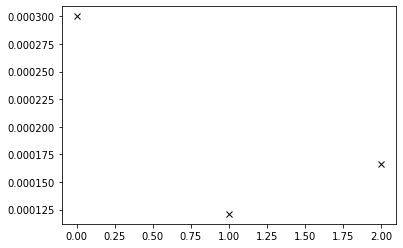

In [73]:
test = dataset.collate(dataset[np.random.choice(dataset.__len__(),N).tolist()]).to(device)
influence(model, test, 3, eps = 0.001)

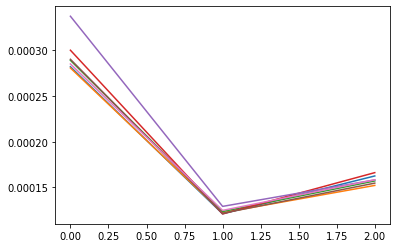

In [82]:
fig, ax = plt.subplots()
for i in range(args['N_dom_feats']):
    derivs = num_deriv(model, test, i, 0.001)
    derivs = derivs.abs().mean(0)
    
    ax.plot(derivs.numpy(),label=args['features'].split(', ')[i])
    

In [148]:
derivs = num_deriv(model, test, 3, 0.05)

(-0.0001, 0.0001)

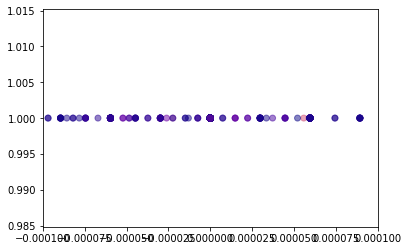

In [125]:
fig, ax = plt.subplots()
ax.scatter(derivs[:,0],np.ones(N),c = scatter_sum(test.x[:,3],test.batch), cmap='plasma',alpha=0.5)
ax.set_xlim(-0.0001,0.0001)

<IPython.core.display.Javascript object>


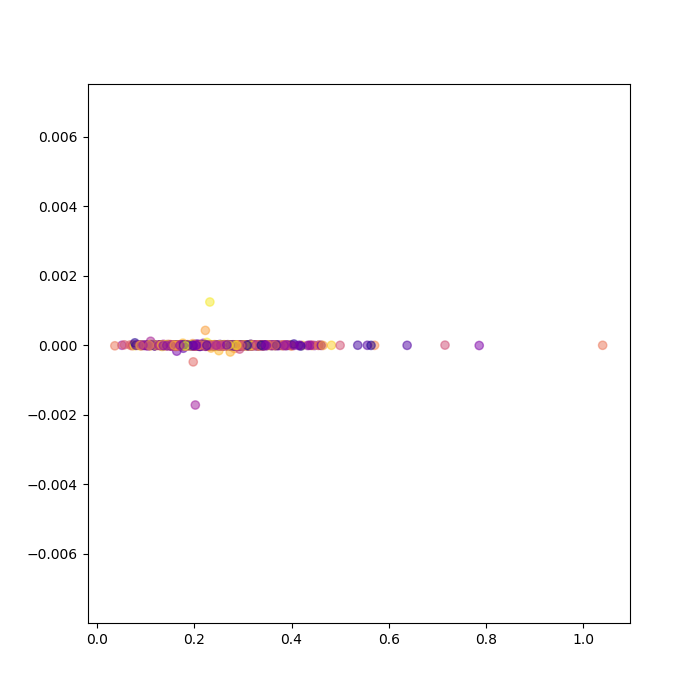

In [149]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(scatter_mean(test.x[:,3],test.batch), derivs[:,0],c = test.y.view(-1,len(args['targets'].split(', ')))[:,1], cmap='plasma',alpha=0.5)
# ax.set_xlim(-0.0001,0.0001)

In [150]:
derivs1 = num_deriv(model, test, 3, 0.01)
derivs2 = num_deriv(model, test, 3, 0.001)

In [153]:
derivs

tensor([[ 5.9605e-07, -3.2783e-06,  2.3842e-06],
        [ 1.1921e-06,  5.9605e-07,  8.3447e-06],
        [ 4.7684e-06,  0.0000e+00,  4.7684e-06],
        ...,
        [-2.9802e-07,  1.1921e-06, -2.3842e-06],
        [ 9.5367e-06, -3.5763e-06,  0.0000e+00],
        [ 2.3842e-06,  0.0000e+00, -4.7684e-06]])

<IPython.core.display.Javascript object>


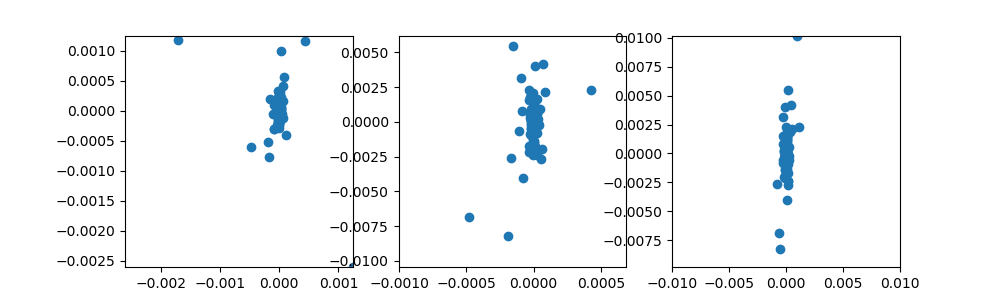

In [157]:
fig, ax = plt.subplots(ncols=3,figsize=(10,3))
ax[0].scatter(derivs[:,0],derivs1[:,0])
ax[0].set_xlim(min(derivs[:,0].min(),derivs1[:,0].min()),max(derivs[:,0].max(),derivs1[:,0].max()))
ax[0].set_ylim(min(derivs[:,0].min(),derivs1[:,0].min()),max(derivs[:,0].max(),derivs1[:,0].max()))
ax[1].scatter(derivs[:,0],derivs2[:,0])
ax[2].scatter(derivs1[:,0],derivs2[:,0])

In [131]:
import shap
# e = shap.DeepExplainer(model, background)

In [238]:
e.supports_model(model)

False

In [239]:
import torch
from torch.autograd import grad

torch.autograd.set_detect_anomaly(False)

def influence(model, src, *args):
    x = src.x.clone()#.requires_grad_()
    src.x = x
    out = model(src, *args).sum(dim=-1)
    
    influences = []
    for j in range(x.size(0)):
        print(j,out[j],grad([out[j]], [x], retain_graph=True, allow_unused=True))
#         influence = grad([out[j]], [x], retain_graph=True, allow_unused=True)[0].abs().sum(dim=-1)
#         influences.append(influence / influence.sum())

    return torch.stack(influences, dim=0)

In [240]:
a = influence(model,test)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [384, 3]], which is output 0 of SubBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [161]:
help(grad)

Help on function grad in module torch.autograd:

grad(outputs: Union[torch.Tensor, Sequence[torch.Tensor]], inputs: Union[torch.Tensor, Sequence[torch.Tensor]], grad_outputs: Union[torch.Tensor, Sequence[torch.Tensor], NoneType] = None, retain_graph: Union[bool, NoneType] = None, create_graph: bool = False, only_inputs: bool = True, allow_unused: bool = False) -> Tuple[torch.Tensor, ...]
    Computes and returns the sum of gradients of outputs w.r.t. the inputs.
    
    ``grad_outputs`` should be a sequence of length matching ``output``
    containing the "vector" in Jacobian-vector product, usually the pre-computed
    gradients w.r.t. each of the outputs. If an output doesn't require_grad,
    then the gradient can be ``None``).
    
    If ``only_inputs`` is ``True``, the function will only return a list of gradients
    w.r.t the specified inputs. If it's ``False``, then gradient w.r.t. all remaining
    leaves will still be computed, and will be accumulated into their ``.grad``
 

In [192]:
with torch.autograd.set_detect_anomaly(True):
    out = model(test)
    grad(outputs = out.sum(-1).sum(), inputs = test.x)

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [285, 3]], which is output 0 of SubBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [182]:
test.x.shape

torch.Size([285, 7])